In [1]:
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from math import sqrt
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import copy
from collections import defaultdict
import matplotlib.pyplot as plt
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [2]:
def extract_data(path,create_test=None):
    X_train=[]
    y_train=[]
    X_test=[]
    y_test=[]

    file=os.listdir(path)

    for entity in file:
        try:
            entityPath=os.listdir(f"{path}/{entity}")
            for i,data in enumerate(entityPath):
                try:
                    current_img=cv2.imread(f"{path}/{entity}/{data}")
                    if current_img is not None:
                        if (create_test is not None and ((len(entityPath)>1) and (i==0))):
                            X_test.append(current_img)
                            y_test.append(entity)
                        else:
                            X_train.append(current_img)
                            y_train.append(entity)
                    else:
                        print(f"{path}/{entity}/{data} is None type")
                except Exception as e:
                    print(f"Erreur avec {path}/{entity}/{data} : {e}")
        except Exception as ex:
            print(f"Erreur avec {path}/{entity} : {ex}")
    
    print(f"Number of training sample : {len(X_train)}\n")
    if create_test is not None:
        print(f"Number of test sample : {len(X_test)}\n")
        return X_train,y_train,X_test,y_test
    else:
        return X_train,y_train

In [3]:
def imgProcess(img,withTorch=None,tr=True):
    if not isinstance(img,np.ndarray):
        print("convertion de l'img")
        img=cv2.imread(img)
    
    #img=extract_face(img) #applique haar cascade
    #img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #RGB -> Gray -> dim(255,255,3)=255*255*3 val de couleur = 195075 vals -> dim(255,255,1) -> 255*255*1 val de couleur = 65025 vals pour l'exemple du 255*255
    img=cv2.resize(img,(100,100)) #dim -> dim(100,100,1) -> 100*100*1 = 10000 val de couleur
    
    if withTorch is None:
        img=img.flatten() #2D -> 1D vec de (10000,1)
    else:
        if tr is not None:
            img=transform(img)
        else:
            img=transform_test(img)
        img=img.unsqueeze(0)
    return img

In [4]:
transform_test=transforms.Compose([
    transforms.ToPILImage(), #transforme en format PIL 
    transforms.ToTensor() #reconvertit l'img en format tensor
])

In [5]:
def distEuclid(img1,img2): #p1(a1,a2,a3...,a10000) p2(b1,b2,b3...,b10000) car chaque image a 10000 val de couleur
    #img1 = img1.astype(np.int32) #pour avoir des valeur négatives sinon en uint8 c'est de 0 à 255 (pas negatif)
    #img2 = img2.astype(np.int32)
    diff=img1.astype(np.int32)-img2.astype(np.int32) #opti

    #distance euclidienne entre deux points (en 2D) p1(x1,y1) et p2(x2,y2): d=hypothénuse du triangle rectangle
    #ainsi d²=a²+b² et d=sqrt(a²+b²) avec a=abs(x1-x2) et b=abs(y1-y2) DONC -> d=sqrt((x1-x2)²+(y1-y2)²)
    #en n dim : d=sqrt((a1-b1)²+(a2-b2)²...+(an-bn)²) = sqrt(sum[1;N]((a-b)²))
    #return sqrt(sum((a-b)**2 for a,b in zip(img1,img2))) #zip -> pour deux listes
    return np.sqrt(np.sum(diff**2)) #opti

In [6]:
def knn_predict(X_train,y_train, newImg,k):
    distances=[]
    for i in range(len(X_train)):
        dist=distEuclid(X_train[i],newImg) #on calcule la distance entre la nouvelle image et toutes les autres images
        distances.append((dist,y_train[i])) #on stock la distance avec le label de chaque image à laquelle on a calculé la distance
    
    distances.sort(key=lambda x: x[0]) #on trie la liste de distances dans l'ordre croissant comme ça les derniers termes sont les plus proche de la nouvelle image
    k_voisins=distances[:k] #on prend les k plus proches voisins

    counts={} #dictionnaire pour compter les labels les plus proches et leur occurences
    for _,label in k_voisins: #dans le tableau c'est [distance,label], ici on veut que le label donc _
        counts[label]=counts.get(label,0)+1 #.get(a,b) = prend la val a si existe sinon prend la val b

    return max(counts,key=counts.get) #compare les valeurs mais renvoie le label du dictionnaire

In [7]:
def knn_evaluate(processed_train,y_train,processed_test,y_test,k,n):
    knn_results=[]
    true=0
    if n is None:
        n=len(processed_test)

    print(f"Number of sample set to : {n}")
    
    for i,img in enumerate(processed_test[:n]):
        print(f"Image KNN : {i}")
        knn_results.append(knn_predict(processed_train,y_train,processed_test[i],k))
        if knn_results[i]==y_test[i]:
            true+=1
    print(f"Accuracy (%) : {100*true/n}")

    return knn_results

In [8]:
def KNN(X_train,y_train,X_test,y_test,k=3,n=None):
    processed_train=[]
    for img in X_train:
        processed_train.append(imgProcess(img))

    processed_test=[]
    for img in X_test:
        processed_test.append(imgProcess(img))
    print("Processing done.\n")

    knn_result=knn_evaluate(processed_train,y_train,processed_test,y_test,k,n)
    return knn_result

In [9]:
def imgPadding(img,padding):
    size=img.shape[0]
    if padding is not None:
        size=size+2*padding
        newImg=np.zeros((size,size,3),dtype=np.uint8)
        for x in range(padding,size-padding):
            for y in range(padding,size-padding):
                newImg[x][y]=img[x-padding][y-padding]
    else:
        newImg=img
    return newImg

In [10]:
def max_pooling(img,dim=2,padding=None,stride=1):
    if padding is not None:
        img=imgPadding(img,padding)
    
    newDim=((img.shape[0]-dim)//stride)+1
    newImg=np.zeros([newDim,newDim,3])
    
    for rgb in range(img.shape[2]):
        for x in range(0,(img.shape[0]//dim)*dim,stride):
            for y in range(0,(img.shape[0]//dim)*dim,stride):
                max=0
                for h in range(dim):
                    for l in range(dim):
                        if img[x+l][y+h][rgb]>max:
                            max=img[x+l][y+h][rgb]
                newImg[((x-dim)//stride)+1][((y-dim)//stride)+1][rgb]=max
    
    return newImg

In [11]:
def average_pooling(img,dim=2,padding=None,stride=1):
    if padding is not None:
        img=imgPadding(img,padding)
    
    newDim=((img.shape[0]-dim)//stride)+1
    newImg=np.zeros([newDim,newDim,3])
    
    for rgb in range(img.shape[2]):
        for x in range(0,(img.shape[0]//dim)*dim,stride):
            for y in range(0,(img.shape[0]//dim)*dim,stride):
                somme=0
                for h in range(dim):
                    for l in range(dim):
                        somme+=img[x+l][y+h][rgb]
                newImg[((x-dim)//stride)+1][((y-dim)//stride)+1][rgb]=somme//dim*dim
    
    return newImg

In [12]:
def CNN_train(X_train,y_train,nb_epoch,labels,batch_size,model=None,patience=5,val_split=None):
    if model is None: #créé un model si on en donne pas
        model=make_model(len(list(set(y_train))))
    
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu") #set le device to the GPU or CPU
    model.to(device) #envoie le model au device

    if val_split is not None:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train,random_state=1) #prend 20% du dataset en validation
        val_dataset = list(zip(X_val, [labels[y] for y in y_val])) #validation dataset
        val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False, collate_fn=lambda x: x)
        best_val_acc = 0
        wait = 0

    y_train_tensor=torch.tensor([labels[y] for y in y_train])

    #X_train_tensor=[imgProcess(img,withTorch=True) for img in X_train] #applique l'imgprocess en mode torch aux images train
    #X_train_tensor=torch.cat(X_train_tensor,dim=0) #stock toutes les images stockées dans X_train_tensor dans un conteneur tensor = créé le batch de taille len(X_train)
    
    #dataset=TensorDataset(X_train_tensor,y_train_tensor) #assemble nos data pour créer le dataset tensor
    dataset=list(zip(X_train,y_train_tensor))
    dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=True,collate_fn=lambda x: x) #shuffle -> pour changer l'ordre des pairs img-label pour pas qu'on choppe des batchs uniquement du même label
    #le dataloader va séparer le dataset de taille N en (N//batch_size)+1 si N%batch_size != 0 -> il y aura N//batch_size batchs complets et un batch plus petit avec les data restantes
    #on peut rajouter le param drop_last=True si on veut supprimer le dernier batch -> +stabilité et certaines couches demandent un full batch (BatchNorm par ex)

    #+ le batch_size est élevé + ce sera précis mais + ça consommera

    criterion = torch.nn.CrossEntropyLoss() #fonction de coût/perte à minimiser -> crossentropy utilisée pour la classification multiclasse
    #applique softmax à la prédiction (qui sont des scores) pour transformer les scores en probabilités puis compare les proba à la classe cible et renvoie une erreur.
    #plus la probabilité de la bonne classe est faible, plus la perte sera grande
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #lr = learning rate -> plus c'est petit plus c'est progressif et donc plus il aura besoin d'apprentissage mais plus il sera précis
    #Adam = Adaptive Moment Estimation -> optimiseur pour réduire la perte. Adam adapte le lr localement donc pas besoin de régler le lr très finement. Utilise le SGD (Stochastic Gradient Descent)
    #SGD -> minimisation de la perte pour chaque exemple individuellement là ou le classique GD minimise la perte globale -> SGD plus bruité (moins stable) mais + rapide

    tabTrain=[]
    tabVal=[] #pour graph les courbes train/val par epoch

    model.train() #active le mode training
    for epoch in range(nb_epoch): # 1 epoque = le moment où le modèle a vu tout le dataset donc une époque = tous les (N//batch_size)+1 batchs
        # plus il y a d'epoch + le model va apprendre et réduire l'erreur mais attention à l'overfitting
        #-> petit dataset(>1000) = 10 to 50 epochs -> moyen dataset (1000 to 100k) = 20 to 100 et grand dataset (>100k) -> 10 to 50
        #SINON -> utiliser early stopping pour être précis qui stop quand la précision sur validation baisse ou n'augmente plus -> à coder soit même
        total_loss=0.0
        correct=0
        total=0

        for batch in dataloader:
            X_raw,labels_batch=zip(*batch)
            img=[imgProcess(image,withTorch=True) for image in X_raw]
            img=torch.cat(img,dim=0)
            img=img.to(device) #envoie les img au device
            labelsT=torch.tensor(labels_batch).to(device) #envoie les labels au device, tout à besoin d'être sur le même device pour être traité

            outputs=model(img) #prédiction des img (forward)
            loss=criterion(outputs,labelsT) #calcul de la perte avec le criterion (ici crossentropy)

            #rétropropagation (backward)
            optimizer.zero_grad() #remet les gradients à 0
            loss.backward()  #calcul les nouveaux gradients

            optimizer.step() #mise à jour des poids

            #partie statistiques (facultatif mais utile)
            total_loss+=loss.item() #additionne la loss de chaque epoch
            _,predicted=torch.max(outputs,1) #prend le score max de la dim 1 de output qui correspond à la classe et prend uniquement la classe associée à ce score max = les classes prédites
            correct+=(predicted==labelsT).sum().item() #compte combien de ces preds sont correctes
            total+=labelsT.size(0) #compte le nb d'img traitées dans cette epoch (labels.size(0)=32 ici vu que c'est le batch_size)
            
        acc=100*correct/total #bonnes prédictions sur l'ensemble de l'epoch en %
        tabTrain.append(acc)
        print(f"\nEpoch : {epoch+1}/{nb_epoch}\n Perte :{total_loss:.4f}\n Précision : {acc:.2f}%")
        
        if val_split is not None:
            true,false,tot=CNN_evaluate(model=model,labels=labels,loader=val_loader,device=device)
            val_acc=sum(true.values())/sum(tot.values()) #calcule l'accuracy du dataset validation
            tabVal.append(100*val_acc)
            if val_acc>best_val_acc:
                best_val_acc=val_acc #si l'acc de la val est meilleure on l'assigne et on reset le timer 
                wait=0
                best_model=copy.deepcopy(model.state_dict()) #on copie le meilleur model
            else:
                if wait>=patience: #on attend le nombre d'epoch max sans amélioration
                    print("Early stopping activated")
                    break
                wait+=1
            print(f"\n Val accuracy : {val_acc*100:.2f}%\n Série sans amélioration : {wait}")
    model.load_state_dict(best_model)
    absc=list(range(len(tabTrain)))
    plt.figure(figsize=(8,5))
    plt.plot(absc,tabTrain,label="Training",marker="o")
    if val_split is not None:
        plt.plot(absc,tabVal,label="Validation",marker="s")
    plt.xlim(1,len(tabTrain))
    plt.ylim(0,100)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    print("Training terminé.")
    plt.show()
    return model

In [13]:
def CNN_evaluate(model,X_test=None,y_test=None,labels=None,batch_size=None,loader=None,device=None,graph=None):
    if device is None:
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
        
    model.eval() #active le mode evaluation

    if loader is None:
        y_test_tensor=[labels[y] for y in y_test] #remplace chaque nom dans y_test par son indice dans labels
        test_dataset=list(zip(X_test,y_test_tensor))
        loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False,collate_fn=lambda x: x)

    """counts={} #dictionnaire pour compter les labels les plus proches et leur occurences
    for _,label in k_voisins: #dans le tableau c'est [distance,label], ici on veut que le label donc _
        counts[label]=counts.get(label,0)+1 #.get(a,b) = prend la val a si existe sinon prend la val b"""
    
    labelF=defaultdict(int) #équivalent à faire labelF={} puis plus tard labelF[label]=labelF.get(label,0)+1 #pour les fausses prédictions
    labelC=defaultdict(int) #pour les correctes
    labelT=defaultdict(int) #pour les totaux

    with torch.no_grad(): #pas de backward (juste forward = pred)
        for batch in loader:
            X_raw,labels_batch=zip(*batch)
            img=[imgProcess(image,withTorch=True,tr=None) for image in X_raw]
            img=torch.cat(img,dim=0)
            img=img.to(device)
            labelsT=torch.tensor(labels_batch).to(device)

            outputs=model(img)
            _,pred=torch.max(outputs,1)
            for i in range(len(labels_batch)):
                label=labelsT[i].item()
                pred[i]=pred[i].item()

                if pred[i]==label:
                    labelC[label]+=1
                else:
                    labelF[label]+=1
                labelT[label]+=1
            
    if graph is not None:
        print(f"Total precision : {sum(labelC.values())/sum(labelT.values())*100:.2f}%")
        precisions={}
        for label in labelT:
            tot=labelT[label]
            correct=labelC.get(label,0)
            precisions[label]=correct/tot if tot>0 else 0
        prec_sorted=sorted(precisions.items(),key=lambda x: x[1])
        labels_ids,values= zip(*prec_sorted)

        id2label = {v: k for k, v in labels.items()}
        class_names=[id2label[i] for i in labels_ids]

        plt.figure(figsize=(12, 5))
        plt.bar(class_names, values, color='skyblue')
        plt.xticks(rotation=45)
        plt.ylabel("Précision par classe")
        plt.title("Performance du modèle par classe")
        plt.tight_layout()
        plt.show()

    return labelC,labelF,labelT

In [14]:
def CNN_inf(img_path,model,labels):
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    img=imgProcess(img_path,withTorch=True).to(device)

    with torch.no_grad():
        output=model(img)
        _,pred=torch.max(output,1)
    
    return labels[pred.item()]

In [15]:
transform=transforms.Compose([
    transforms.ToPILImage(), #transforme en format PIL
    transforms.RandomHorizontalFlip(), #0.5 de proba d'inverser la gauche et la droite de l'img pour rendre le modèle invariant à la symétrie
    transforms.RandomRotation(15), #applique rota random entre -10° et +10° 
    transforms.ColorJitter(brightness=0.3,contrast=0.3,saturation=0.2,hue=0.02), #altère aléatoirement la luminosité et le contraste de l'image
    transforms.ToTensor() #reconvertit l'img en format tensor
])

"""transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(p=0.9),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor()
])
"""

'transform = transforms.Compose([\n    transforms.ToPILImage(),\n    transforms.Resize((100, 100)),\n    transforms.RandomHorizontalFlip(p=0.9),\n    transforms.RandomRotation(15),\n    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),\n    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),\n    transforms.ToTensor()\n])\n'

In [16]:
def make_model1(nb_classes):
    model=nn.Sequential(
        nn.Conv2d(1,16,kernel_size=3,padding=1), #(1,100,100) -> (16,100,100)           = 1*3*3*16+16 = 160
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(16,100,100) -> ((100-2)//2)+1 = 49+1 = 50 donc -> (16,50,50)
        nn.Conv2d(16,32,kernel_size=3,padding=1), #(16,50,50) -> (32,50,50)             =16*3*3*32+32 = 4640
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(32,50,50) -> ((50-2)//2)+1 = 25 -> (32,25,25)
        nn.Flatten(), #(32,25,25) -> (32*25*25) = (20000)
        #nn.Dropout(0.3) #pour éviter l'overfitting
        nn.Linear(20000,128),       # = 20000*128 +128 = 2560128
        nn.ReLU(),
        nn.Linear(128,nb_classes)       # = 128*nb class + nb class
    )
    return model        # 160+4640+2560128+129*nbclass = 2 564 928 + 129*nbclass PARAMS

In [17]:
def make_model2(nb_classes):
    model=nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, padding=1),  # → (16, 100, 100)
        nn.ReLU(),
        nn.MaxPool2d(2, 2),                         # → (16, 50, 50)

        nn.Conv2d(16, 32, kernel_size=3, padding=1), # → (32, 50, 50)
        nn.ReLU(),
        nn.MaxPool2d(2, 2),                         # → (32, 25, 25)

        nn.Conv2d(32, 64, kernel_size=3, padding=1), # → (64, 25, 25)
        nn.ReLU(),
        nn.MaxPool2d(2, 2),                         # → (64, 12, 12)

        nn.AdaptiveAvgPool2d((4, 4)),               # → (64, 4, 4) (plus robuste aux tailles)
        nn.Flatten(),                               # → 64*4*4 = 1024

        nn.Linear(1024, 128),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(128, nb_classes)
    )
    return model

In [18]:
def make_model3(nb_classes): #modèle VGG-Face modifié
    model=nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (1,100,100) → (32,100,100)
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),  # → (32,100,100)
        nn.ReLU(),
        nn.MaxPool2d(2, 2),                          # → (32,50,50)

        # Block 2
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),                          # → (64,25,25)

        # Block 3
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),                          # → (128,12,12)

        # Adaptive pooling for flexibility
        nn.AdaptiveAvgPool2d((4, 4)),                # → (128,4,4)
        nn.Flatten(),                                # → 2048

        nn.Linear(2048, 256),
        nn.ReLU(),
        nn.Dropout(0.4), 

        nn.Linear(256, nb_classes)
    )
    return model

In [19]:
def make_model4(nb_classes):
    model=nn.Sequential( #input (1,100,100)
        nn.Conv2d(1,16,kernel_size=3,padding=1), #(1,100,100) -> (16,100,100)           1*16*3*3+16 = 160
        nn.ReLU(),
        nn.MaxPool2d(2,2), #-> (16,100,100) -> ((100-2)//2)+1=50 -> (16,50,50)

        nn.Conv2d(16,32,kernel_size=3,padding=1), #(16,50,50)->(32,50,50)               16*32*3*3 +32 = 4640
        nn.ReLU(),
        nn.Conv2d(32,32,kernel_size=3,padding=1), #(32,50,50) -> (32,50,50)             32*32*3*3 +32 = 9248
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(32,50,50) -> ((50-2)//2)+1 = 25 donc -> (32,25,25)

        nn.Conv2d(32,64,kernel_size=3,padding=1), #(32,25,25) -> (64,25,25)             32*64*3*3 +64 = 18496
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size=3,padding=1), #(64,25,25) -> (64,25,25)             64*64*3*3 +64 = 36928
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size=3,padding=1), #(64,25,25) -> (64,25,25)             64*64*3*3 +64 = 36928
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(64,25,25) -> ((25-2)//2)+1 =12 donc -> (64,12,12)

        nn.Conv2d(64,128,kernel_size=3,padding=1), #(64,12,12)->(128,12,12)             64*128*3*3 +128 = 73856
        nn.ReLU(),
        nn.Conv2d(128,128,kernel_size=3,padding=1), #(128,12,12) ->(128,12,12)          128*128*3*3 +128 = 147584
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(128,12,12) -> ((12-2)//2)+1 =6 donc -> (128,6,6)

        nn.Conv2d(128,256,kernel_size=3,padding=1), #(128,6,6) -> (256,6,6)             128*256*3*3+256 = 295168
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(256,6,6) -> (256,3,3)

        nn.Flatten(), #(256,3,3) -> (256*3*3) = (2304)
        nn.Linear(2304,256), #(2304) -> (256)       2304*256 +256 = 590080
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256,128), #(256) -> (128)         256*128+128= 32896
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128,nb_classes) #(128) -> (nb_classes)    129*nb_classes  donc nb tot de params : 160+4640+9248+18496+36928+36928+73856+147584+295168+590080+32896 +129*nb_classes = 1245984
    )
    return model

In [20]:
def make_model(nb_classes):
    model=nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,padding=1), #(3,100,100) -> (32,100,100)
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,32,kernel_size=3,padding=1), #(32,100,100) -> (32,100,100)
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(32,100,100) -> (32,50,50)

        nn.Conv2d(32,64,kernel_size=3,padding=1), #(32,50,50) -> (64,50,50)
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size=3,padding=1), #(64,50,50) -> (64,50,50)
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(64,50,50) -> (64,25,25)

        nn.Conv2d(64,128,kernel_size=3,padding=1), #(64,25,25) -> (128,25,25)
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128,128,kernel_size=3,padding=1), #(128,25,25) -> (128,25,25)
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(128,25,25) -> (128,12,12)

        nn.AdaptiveAvgPool2d((1,1)), #(128,12,12) -> (128,1,1)
        nn.Flatten(),

        nn.Linear(128,256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256,nb_classes)
    )
    return model

In [21]:
def extract_face(img):
    if not isinstance(img,np.ndarray):
        img=cv2.imread(img) #si on passe un path ça read l'img

    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(60,60)
    )

    if len(faces)==0:
        return img #retourne l'img si aucun visage n'est detecté
    
    #si je veux detecter tous les visages présents je dois faire une boucle for x,y,w,h in faces: et return une liste d'img crops
    x,y,w,h=faces[0] #faces retourne n tuples (x,y,h,w) correspondants aux coords du visage
    face=img[y:y+h,x:x+w] #retourne l'img crop aux coords detectées
    return face

In [22]:
def extract_face_and_eyes(img):
    if not isinstance(img,np.ndarray):
        img=cv2.imread(img)

    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(60,60)
    )

    if len(faces)==0:
        return [],[]
    
    x,y,w,h=faces[0]
    face=img[y:y+h,x:x+w]
    eyes=eye_cascade.detectMultiScale(cv2.cvtColor(face,cv2.COLOR_BGR2GRAY))
    if len(eyes)==2:
        if eyes[0][0]<eyes[1][0]:
            x2=eyes[0][0]
            w2=eyes[1][0]+eyes[1][2]-x2
        else:
            x2=eyes[1][0]
            w2=eyes[0][0]+eyes[0][2]-x2
        if eyes[0][1]<eyes[1][1]:
            y2=eyes[0][1]
            h2=eyes[1][1]+eyes[1][3]-y2
        else:
            y2=eyes[1][1]
            h2=eyes[0][1]+eyes[0][3]-y2
        imgEyes=face[y2:y2+h2,x2:x2+w2]
        return face,imgEyes
    else:
        return face,[]
    

In [26]:
X,y=extract_data("DataFaces")
X_train=[]
y_train=[]
for i,img in enumerate(X):
    _,eyes=extract_face_and_eyes(img)
    if len(eyes)!=0:
        X_train.append(eyes)
        y_train.append(y[i])
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=0.2,random_state=1,stratify=y_train)
labels={label:i for i,label in enumerate(sorted(set(y_train)))} #list(set(y_train)) sort les val uniques en list et sorted les range dans l'ordre alphabétique

Number of training sample : 17534



In [27]:
print(len(X_train))

6340


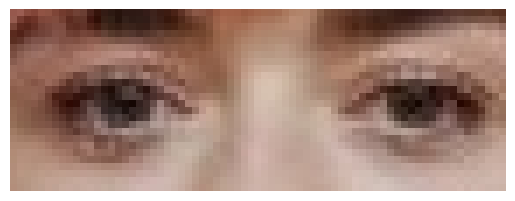

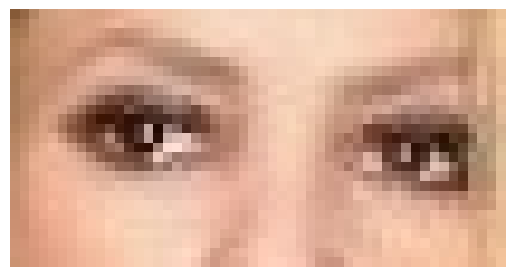

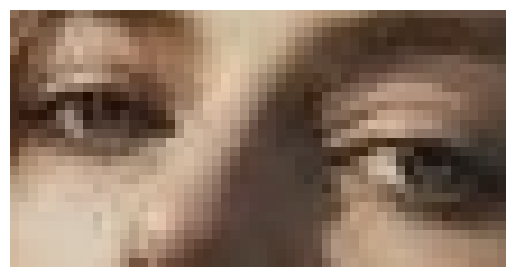

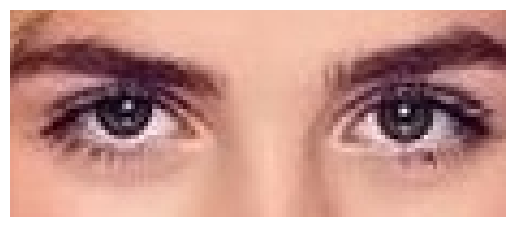

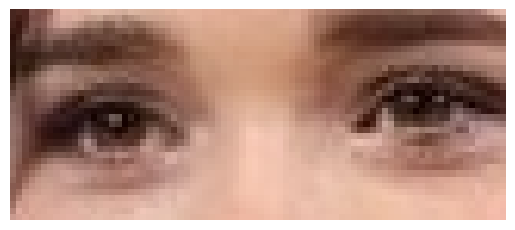

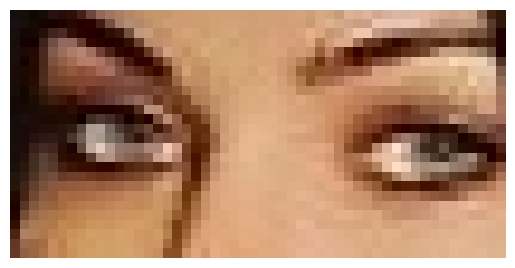

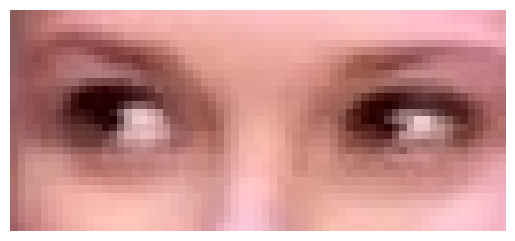

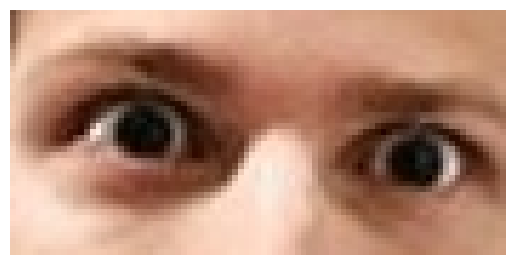

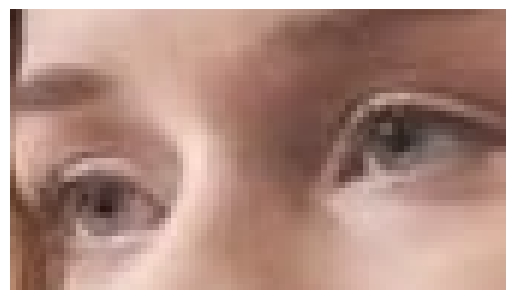

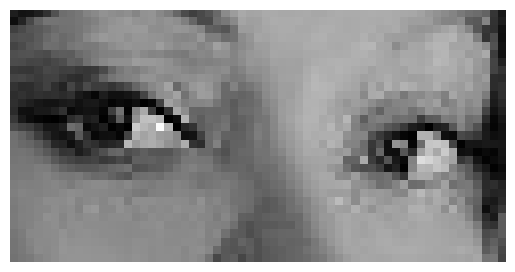

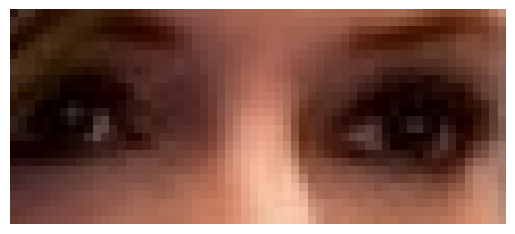

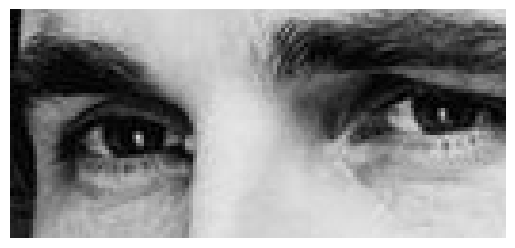

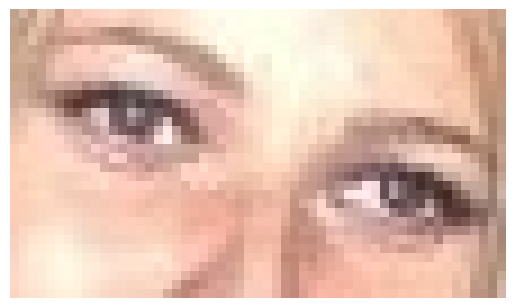

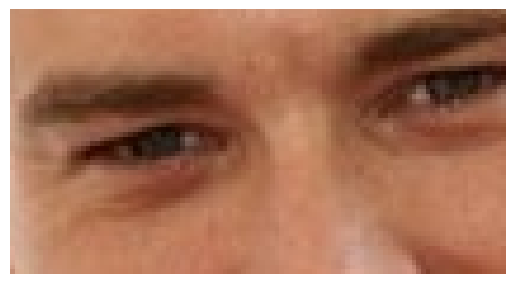

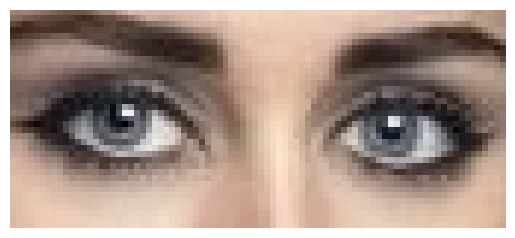

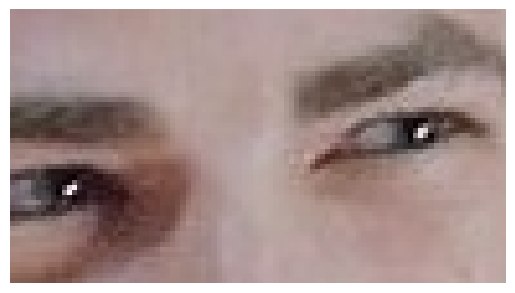

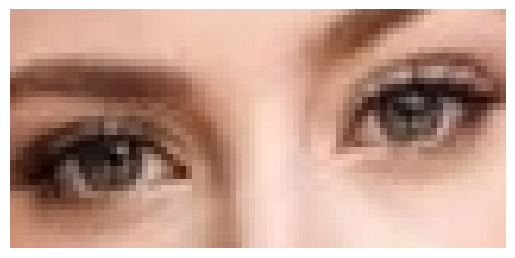

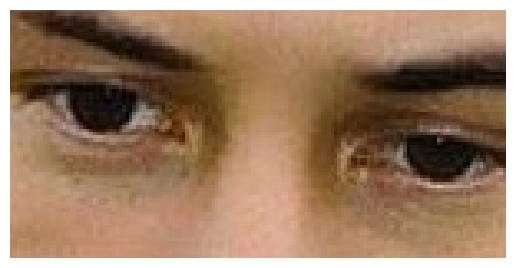

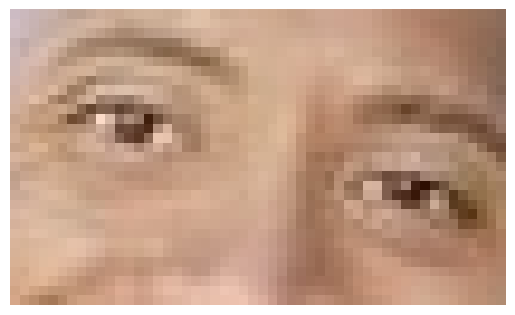

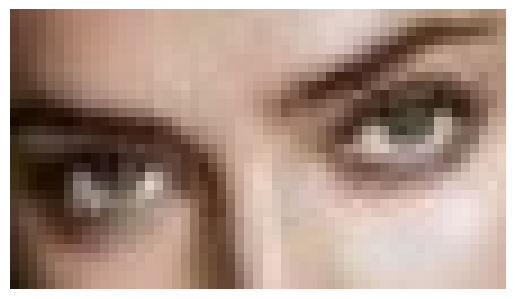

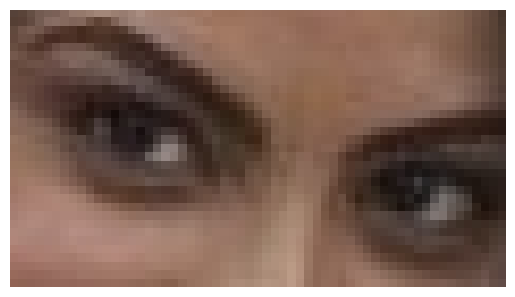

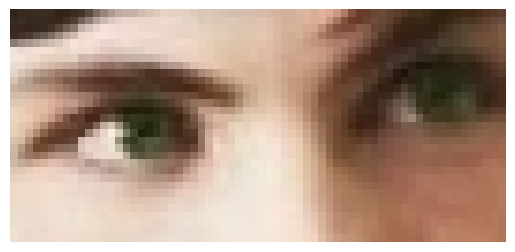

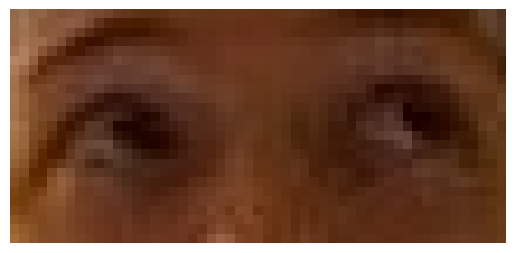

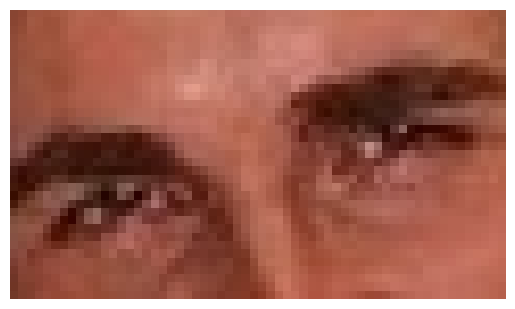

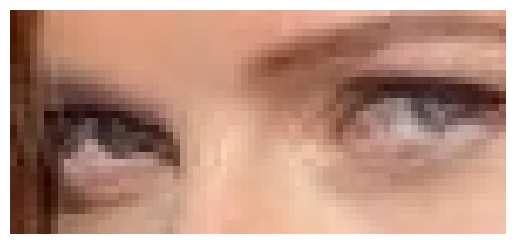

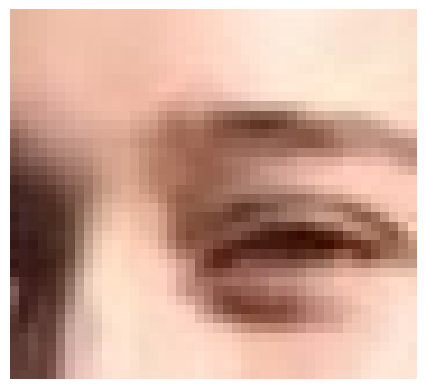

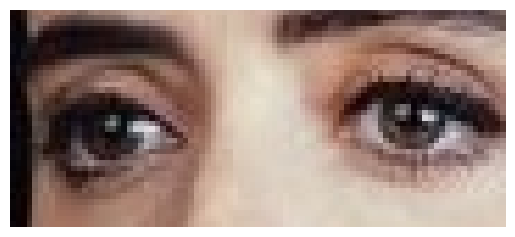

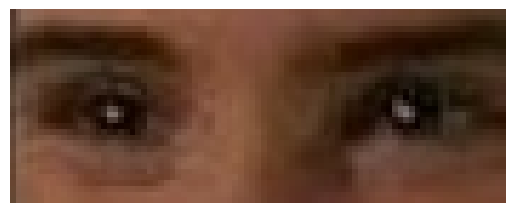

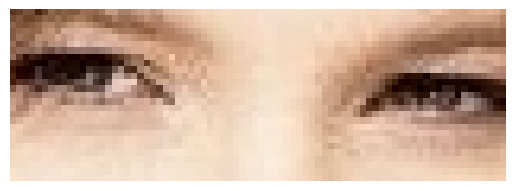

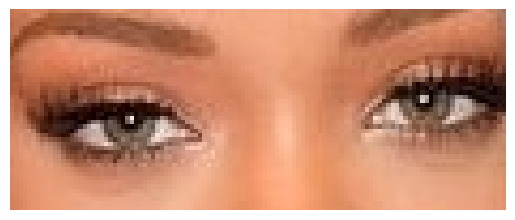

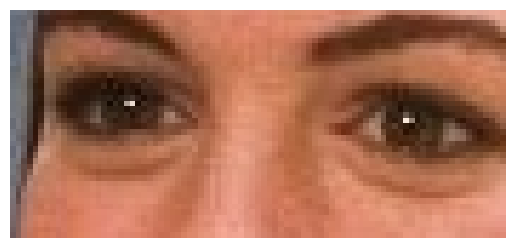

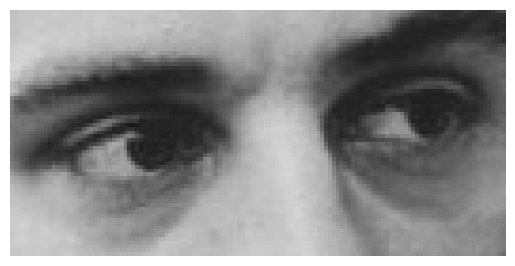

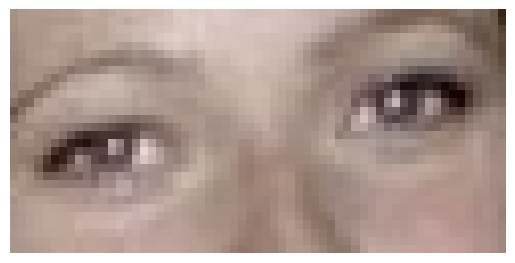

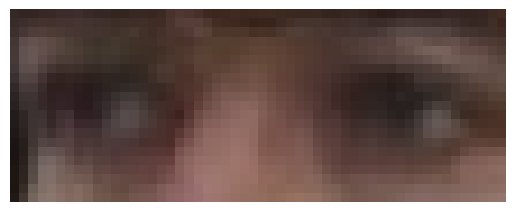

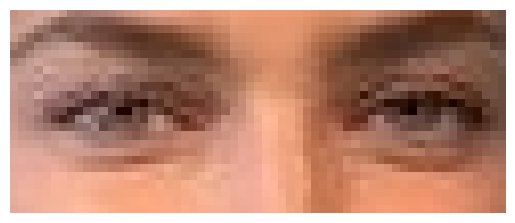

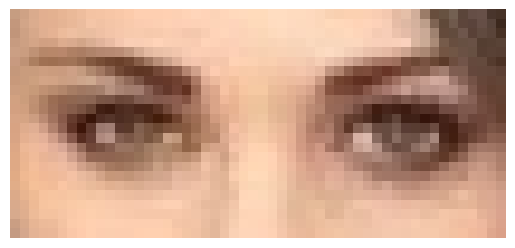

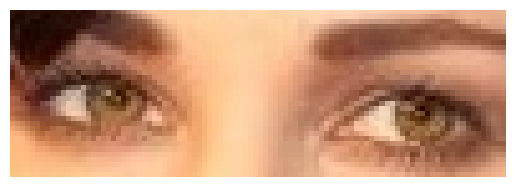

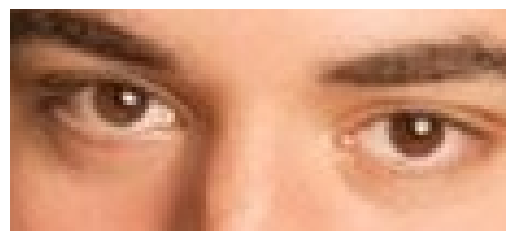

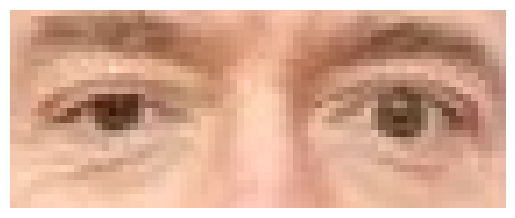

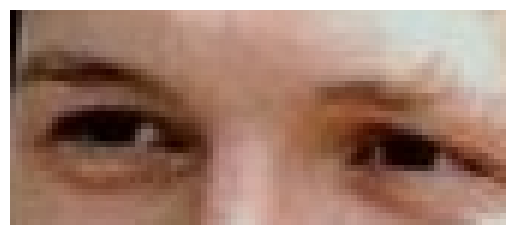

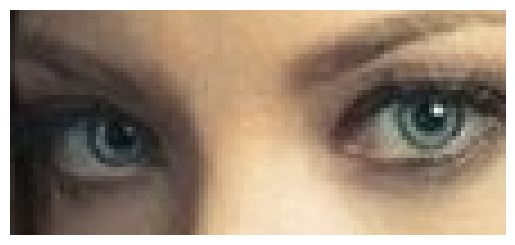

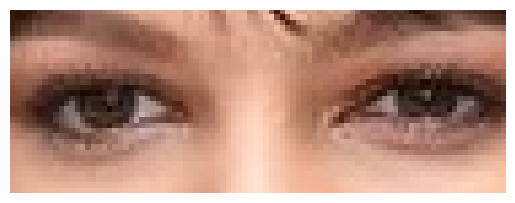

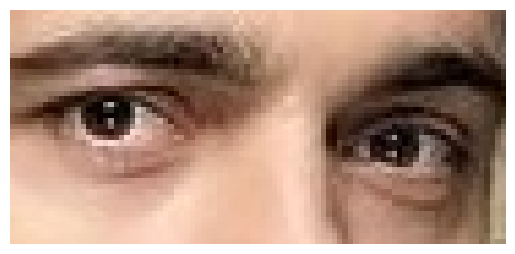

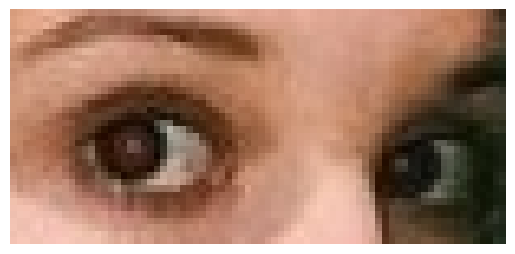

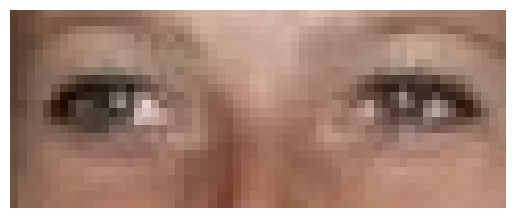

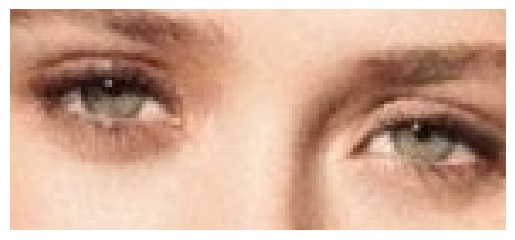

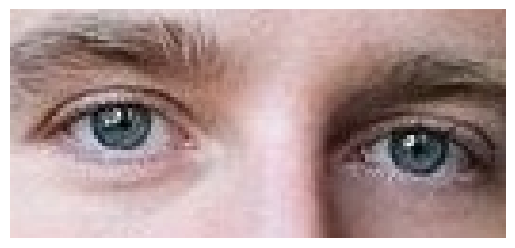

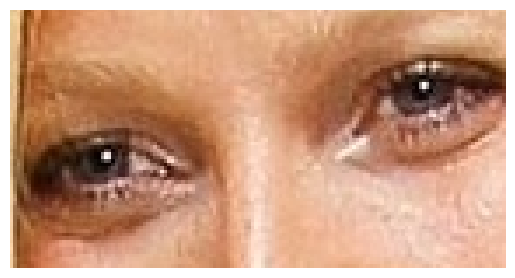

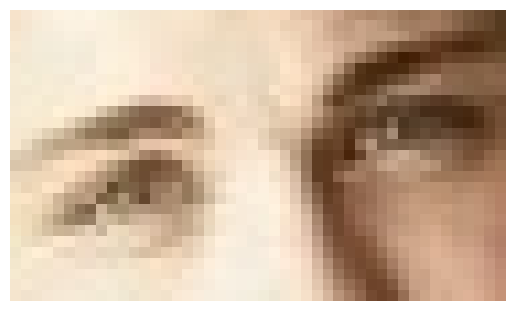

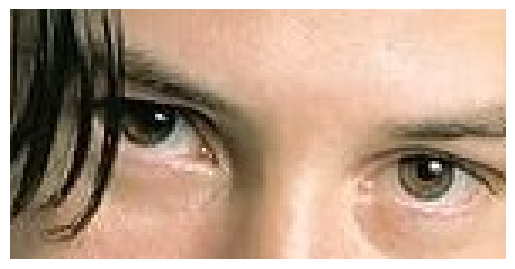

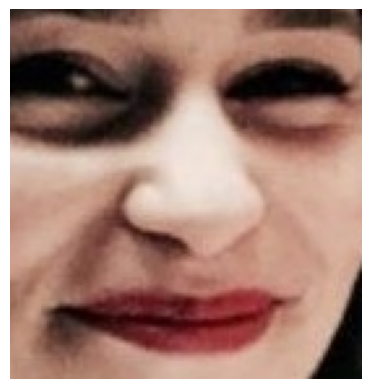

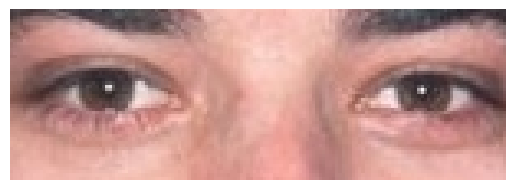

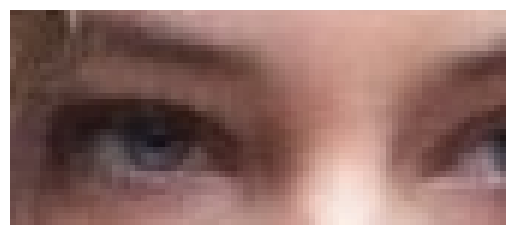

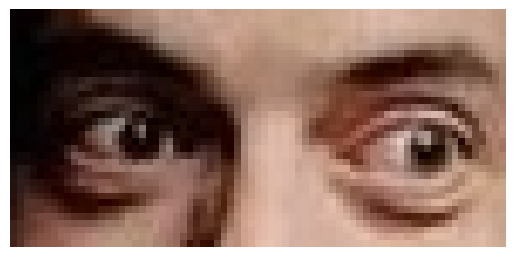

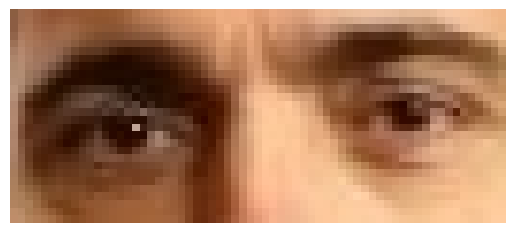

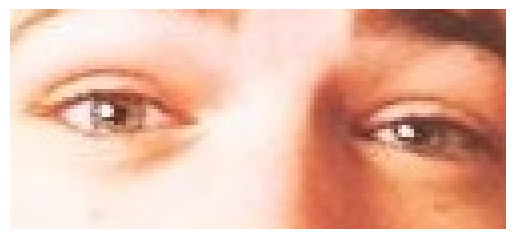

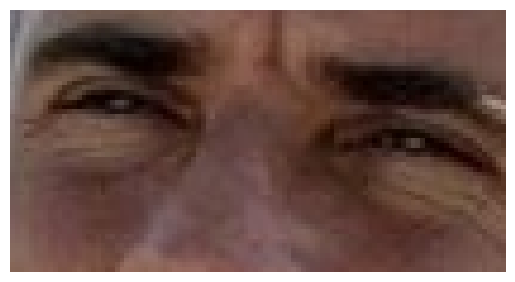

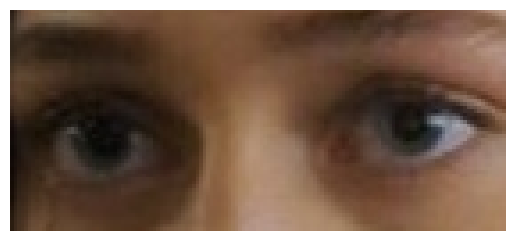

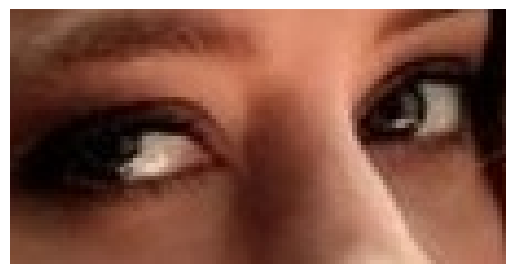

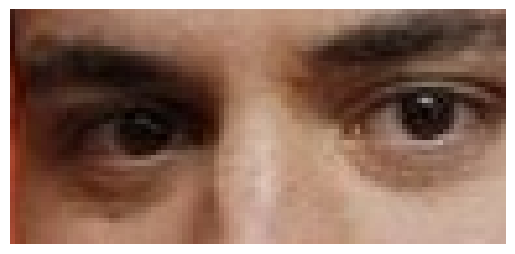

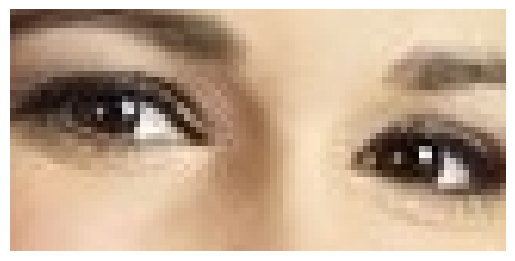

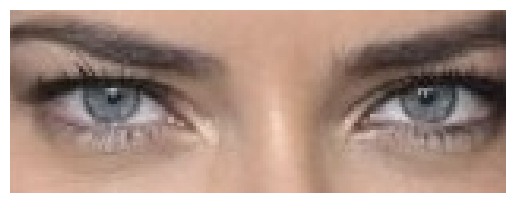

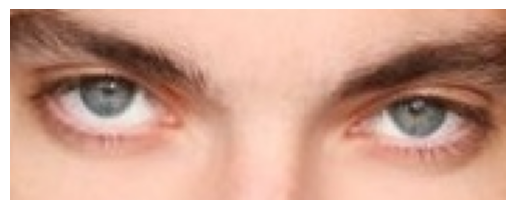

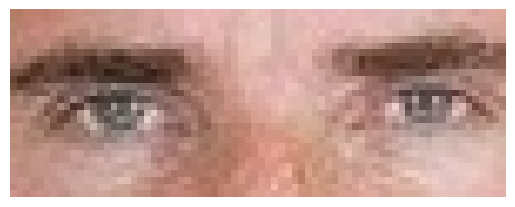

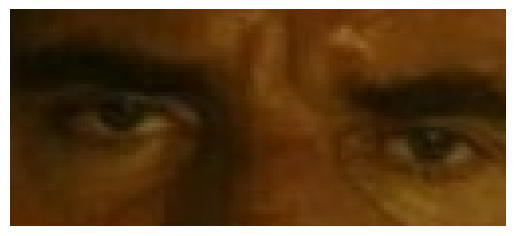

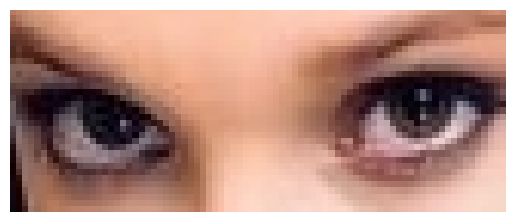

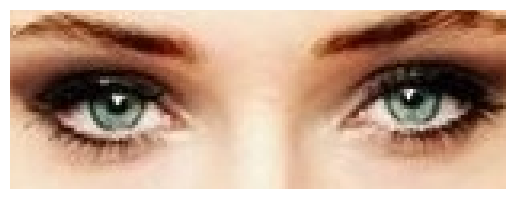

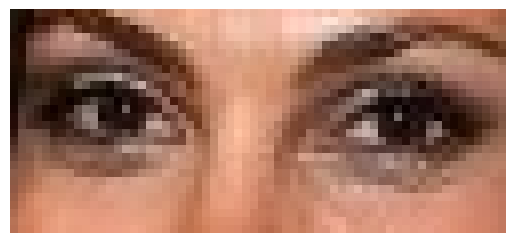

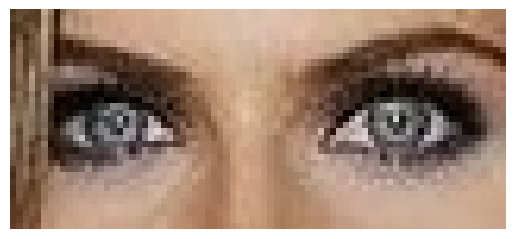

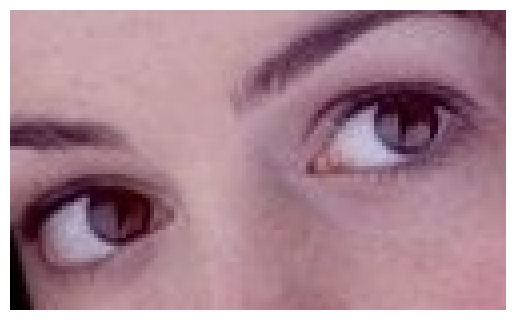

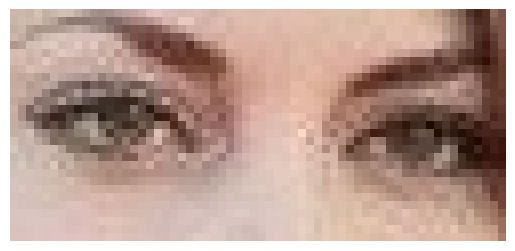

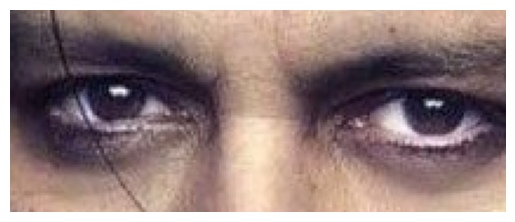

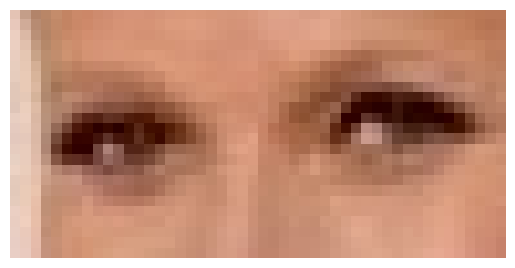

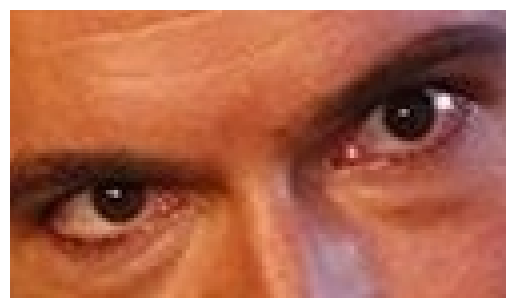

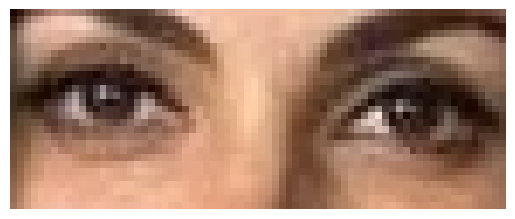

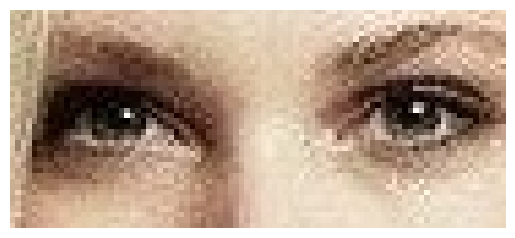

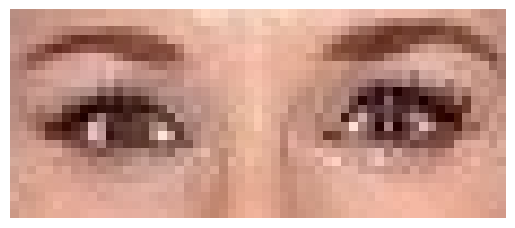

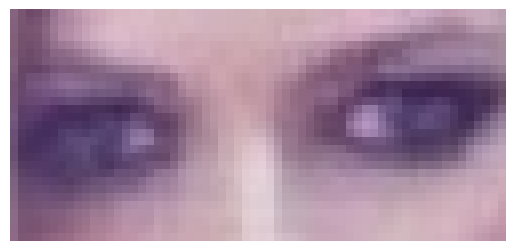

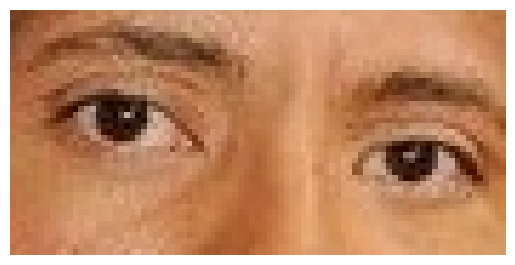

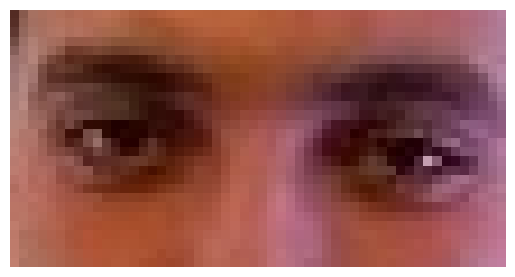

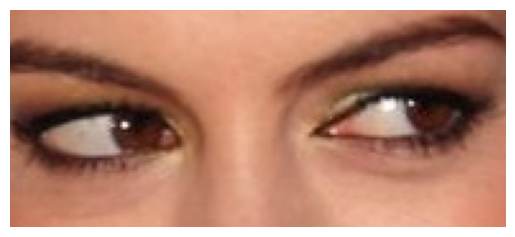

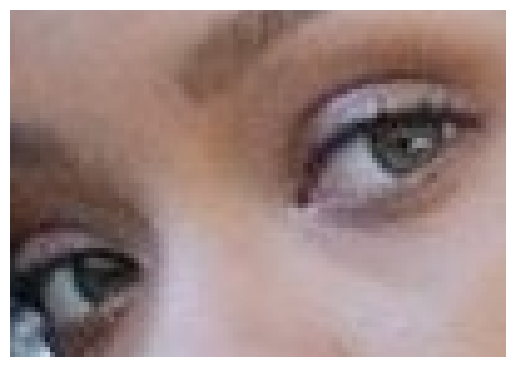

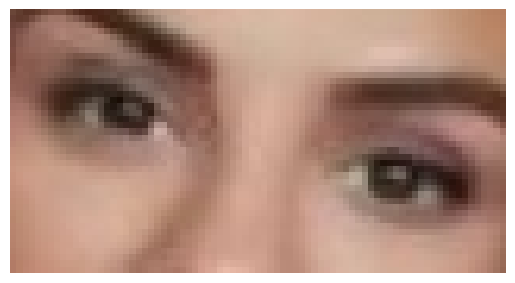

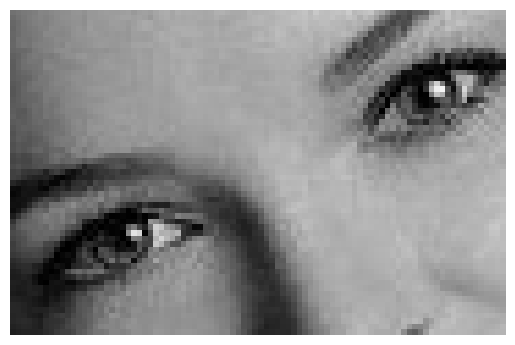

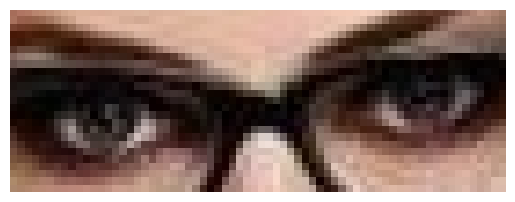

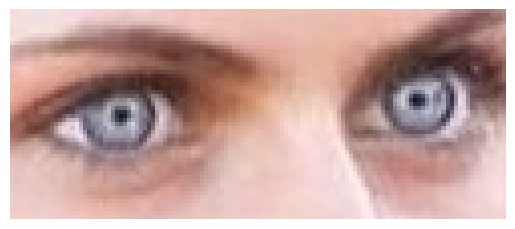

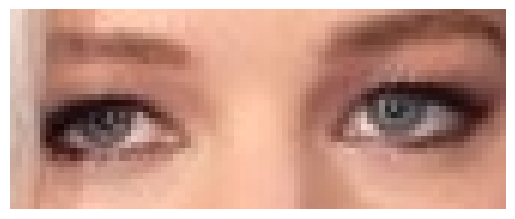

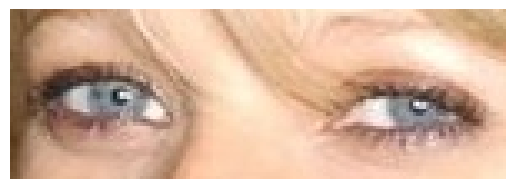

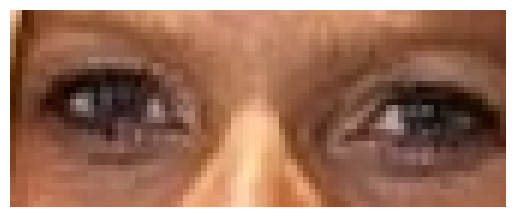

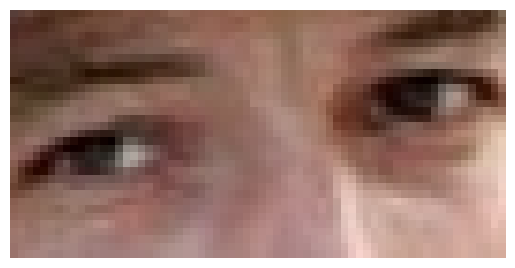

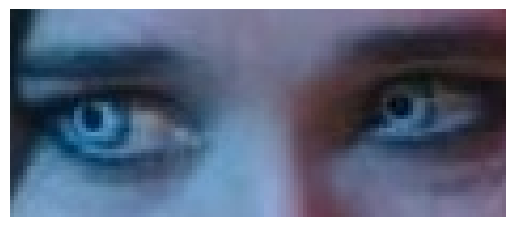

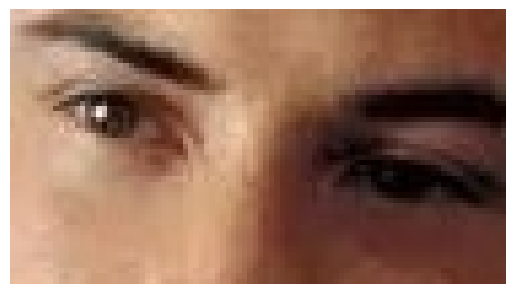

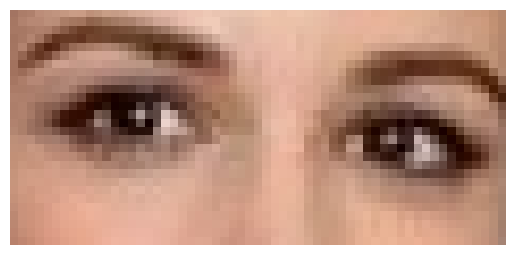

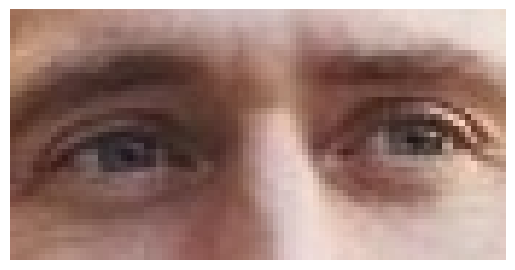

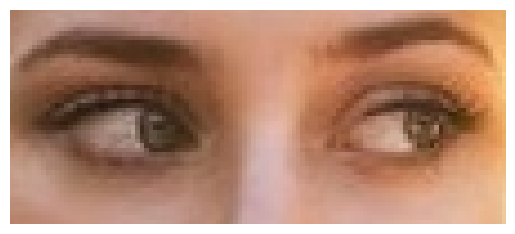

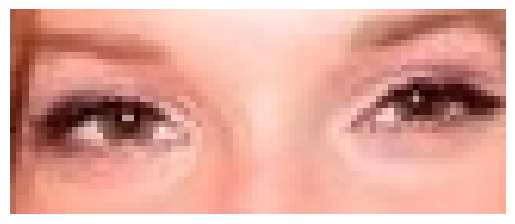

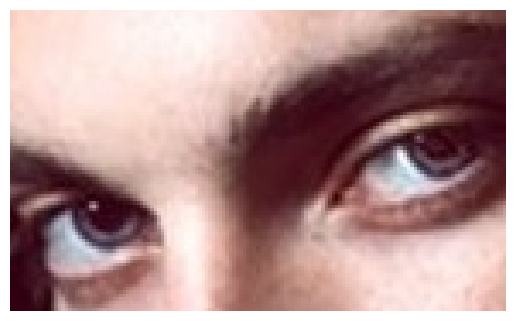

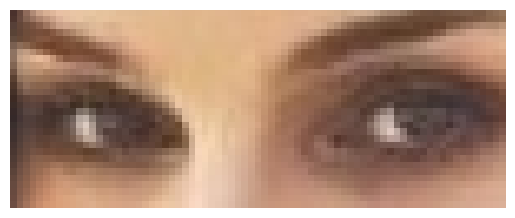

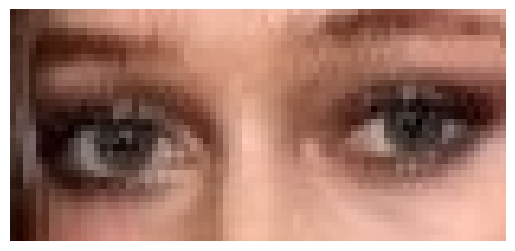

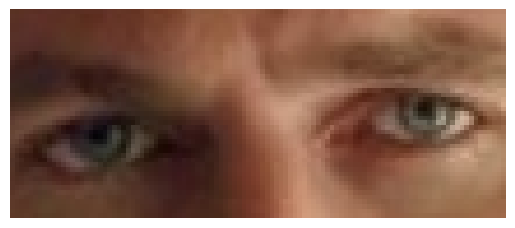

In [29]:
for u in range(100):
    img=cv2.cvtColor(X_train[u],cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [22]:
model=CNN_train(X_train=X_train_faces,y_train=y_train,nb_epoch=150,labels=labels,batch_size=32,patience=50,val_split=True)
labelC,labelF,labelT=CNN_evaluate(model,X_test=X_test_faces,y_test=y_test,labels=labels,batch_size=32,graph=True)

NameError: name 'X_train_faces' is not defined

Total precision : 57.34%


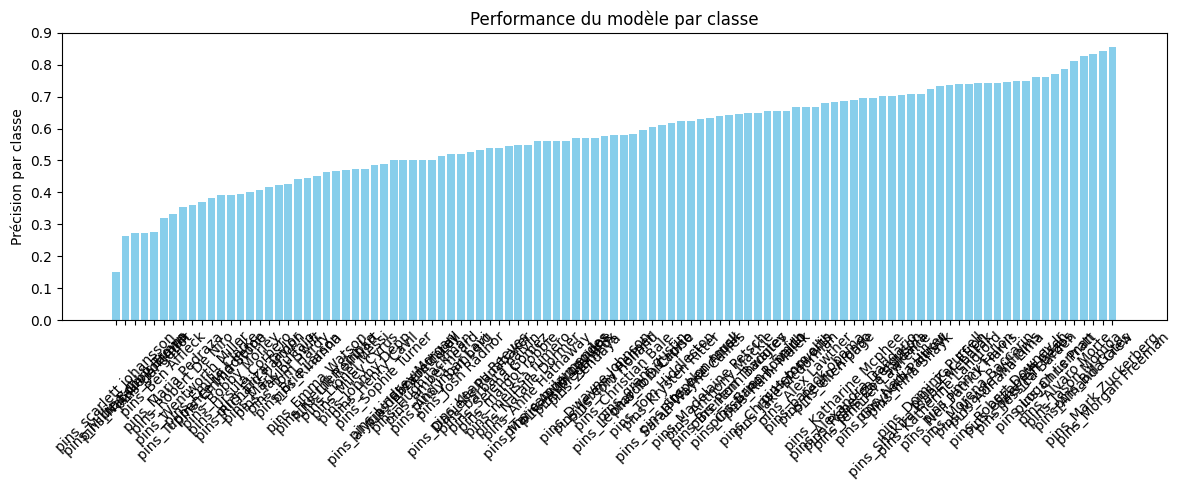

(defaultdict(int,
             {53: 18,
              88: 26,
              73: 20,
              41: 24,
              2: 31,
              0: 32,
              65: 17,
              85: 13,
              68: 25,
              20: 19,
              103: 6,
              4: 19,
              98: 22,
              26: 11,
              93: 18,
              12: 27,
              71: 11,
              10: 20,
              64: 17,
              45: 28,
              51: 29,
              80: 17,
              104: 24,
              94: 33,
              32: 22,
              16: 21,
              100: 19,
              79: 23,
              86: 28,
              1: 20,
              7: 16,
              50: 24,
              57: 17,
              27: 19,
              67: 21,
              61: 19,
              72: 35,
              14: 15,
              8: 18,
              56: 24,
              33: 21,
              91: 16,
              62: 22,
              63: 9,
              54: 1

In [46]:
CNN_evaluate(model,X_test=X_test_faces,y_test=y_test,labels=labels,batch_size=32,graph=True)

In [ ]:
n=len(os.listdir("Models"))
torch.save(model.state_dict(), f"model-{n}.pt")
print(f"Sauvegardé sous le nom : model-{n}.pt")


Sauvegardé sous le nom : model-1.path


In [35]:
torch.save(model.state_dict(), f"Models/model-6421.pt")